In [1]:
# This notebook was derived from https://www.kaggle.com/jerrypeng/dsp-tutorial-3-demos-for-speech-processing
# Assumption is that you work in Python 3 environment
# Load the following Python libraries
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
# Assumption that audio-files are stored in wav format in a data folder
audioFilePath = os.listdir("data")
wavfilename = 'data/' + audioFilePath[0]

In [3]:
# load the wav file with librosa
wave, fs = librosa.load(wavfilename, sr=None)
print('sample frequency = ' + str(fs/1000) + ' kHertz')
recordingDurationMinutes = (wave.size / fs) / 60
print('duration of recording = ' + str(round(recordingDurationMinutes,1)) + ' minutes')

sample frequency = 44.1 kHertz
duration of recording = 50.6 minutes


In [4]:
if recordingDurationMinutes > 10: # select middle 2 minutes if the recording is longer than 2 minutes
    midpoint = round(wave.size / 2)
    wave = wave[(midpoint-(fs * 60 * 2)+1):(midpoint+(fs * 60 * 2))]

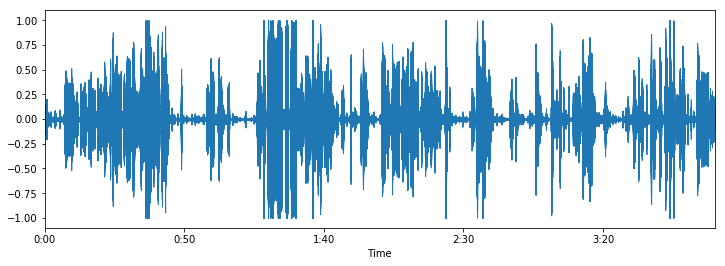

In [5]:
plt.figure(figsize=(12, 4))
librosa.display.waveplot(wave, sr=fs)
plt.show()

In [6]:
STFT = librosa.stft(wave, n_fft=2048) # Short-time Fourier transform (STFT)
mag, phase = librosa.magphase(STFT) #Separate a complex-valued spectrogram into its magnitude and phase components
dBspectrogram = librosa.amplitude_to_db(mag, ref=np.max) # Convert an amplitude spectrogram to dB-scaled spectrogram.

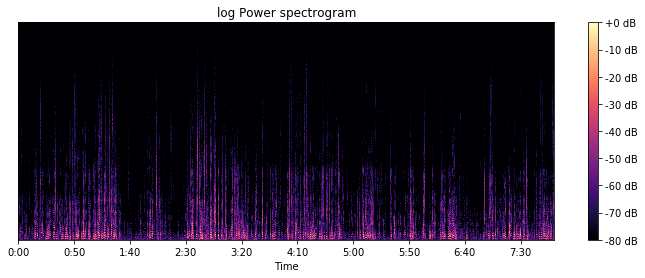

In [7]:
plt.figure(figsize=(12,4))
librosa.display.specshow(dBspectrogram, x_axis='time')
plt.title('log Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [8]:
frame_len = int(20 * fs /1000) # 20ms
frame_shift = int(10 * fs /1000) # 10ms

In [9]:
# calculate RMS energy for each frame
rmse = librosa.feature.rmse(wave, frame_length=frame_len, hop_length=frame_shift)
rmse = rmse[0]
rmse = librosa.util.normalize(rmse, axis=0) # normalize first axis to -1,1

In [10]:
# calculate zero-crossing rate
zrc = librosa.feature.zero_crossing_rate(wave, frame_length=frame_len, hop_length=frame_shift, threshold=0)
zrc = zrc[0]
zrc = librosa.util.normalize(zrc, axis=0) # normalize first axis to -1,1

In [11]:
# 4 minutes data => 240 seconds => 24000 frames of 10ms
len(rmse.T)

24000

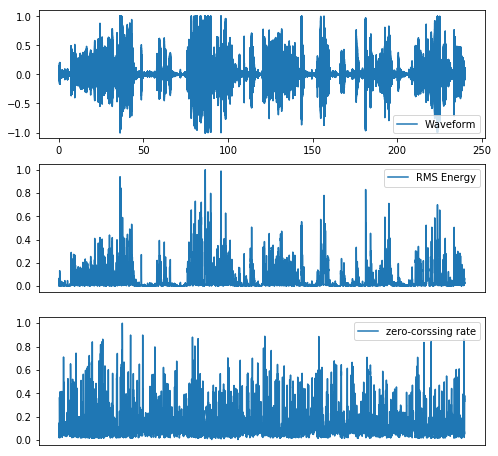

In [12]:
# Plot RMSE and ZCR
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
t = np.linspace(0, len(wave)/fs, len(wave))
plt.plot(t, wave, label='Waveform')
plt.legend(loc='best')

plt.subplot(3, 1, 2)
plt.plot(rmse.T, label='RMS Energy')
plt.xticks([])
plt.legend(loc='best')

plt.subplot(3, 1, 3)
plt.plot(zrc.T, label='zero-corssing rate')
plt.xticks([])
plt.legend(loc='best')
plt.show()

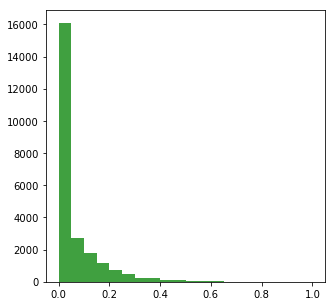

In [13]:
# set threshold of speech and silence
plt.figure(figsize=(5, 5))
n, bins, patches = plt.hist(rmse.T, 20, facecolor='g', alpha=0.75)

In [14]:
frame_idxs = np.where( (rmse > 0.1) | (zrc > 0.6) )[0]

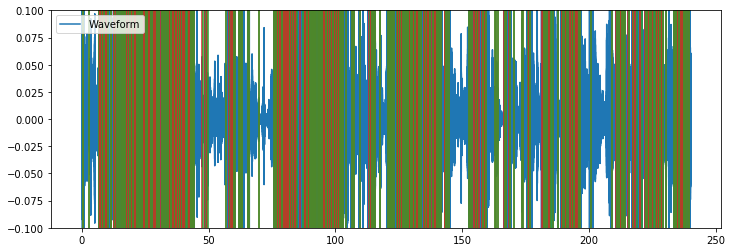

In [15]:
# get start-points and end-points of speech
def getboundaries(frame_idxs):
    start_idxs = [frame_idxs[0]]
    end_idxs = []

    shapeofidxs = np.shape(frame_idxs)
    for i in range(shapeofidxs[0]-1):
        if (frame_idxs[i + 1] - frame_idxs[i]) != 1:
            end_idxs.append(frame_idxs[i])
            start_idxs.append(frame_idxs[i+1])

    end_idxs.append(frame_idxs[-1])
    # del the last boundaries if it is both start point and end point.
    if end_idxs[-1] == start_idxs[-1]:
        end_idxs.pop()
        start_idxs.pop()
    assert len(start_idxs) == len(end_idxs), 'Error! Num of start_idxs doesnt match Num of end_idxs.'
    start_idxs = np.array(start_idxs)
    end_idxs = np.array(end_idxs)
    start_t = start_idxs * frame_shift / fs
    end_t = end_idxs * frame_shift / fs
    return start_t, end_t

start_t, end_t = getboundaries(frame_idxs)


plt.figure(figsize=(12, 4))
t = np.linspace(0, len(wave)/fs, len(wave))
plt.plot(t, wave, label='Waveform')
plt.ylim(-0.1,0.1)
for s, e in zip(start_t, end_t):
    plt.axvline(x=s, color='#d62728') # red vertical line
    plt.axvline(x=e, color='#2ca02c') # green vertical line
    
plt.legend(loc='best')
plt.show()

# Pitch estimation with Librosa

In [16]:
frame_len = int(20 * fs /1000) # 20ms
frame_shift = int(10 * fs /1000) # 10ms
# Slice a time series into overlapping
frames = librosa.util.frame(wave, frame_length=frame_len, hop_length=frame_shift)
# Pitch tracking on thresholded parabolically-interpolated STFT:
pitches, magnitudes = librosa.core.piptrack(wave, sr=fs, hop_length=frame_shift, threshold=0.75)

In [17]:
def extract_max(pitches, shape):
    new_pitches = []
    for i in range(0, shape[1]):
        new_pitches.append(np.max(pitches[:,i]))
    return new_pitches

def smooth(x,window_len=11,window='hanning'):
        if window_len<3:
                return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
                raise(ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
        s=np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
        if window == 'flat': #moving average
                w=np.ones(window_len,'d')
        else:
                w=eval('np.'+window+'(window_len)')
        y=np.convolve(w/w.sum(),s,mode='same')
        return y[window_len:-window_len+1]

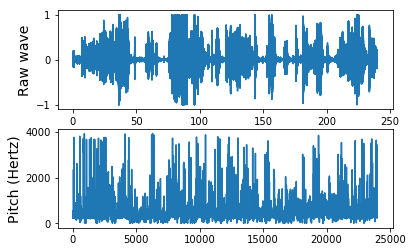

In [18]:
pitch_track = extract_max(pitches, pitches.shape)
pitch_smoothtrack = smooth(pitch_track, window_len=10)
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(t, wave)
plt.ylabel('Raw wave', fontsize=14)
plt.subplot(2, 1, 2)
plt.plot(pitch_smoothtrack)
plt.ylabel('Pitch (Hertz)', fontsize=14)
plt.show()

# Chromagram

In [19]:
music = wave[0:(2*fs),] # let's select first two seconds of the audio data
chroma = librosa.feature.chroma_stft(y=music, sr=fs, n_fft=2048, hop_length=20)

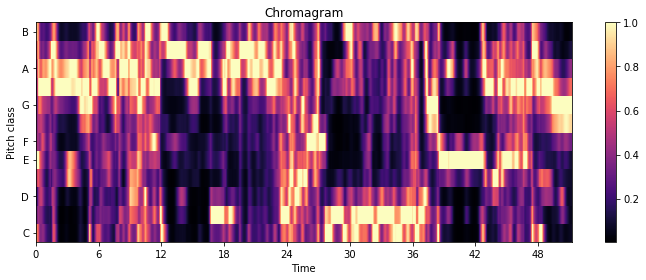

In [20]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', sr = fs)
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()

# Calculate mfcc

In [99]:
mfccs = librosa.feature.mfcc(y=music, sr=fs, n_mfcc = 128)

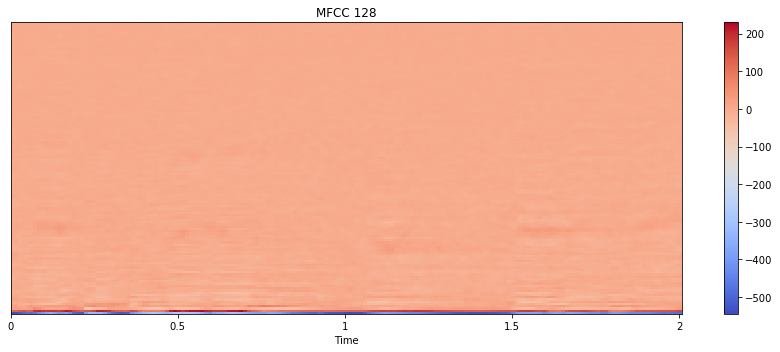

In [101]:
plt.figure(figsize=(12, 5))
librosa.display.specshow(mfccs, x_axis='time',sr=fs)
plt.colorbar()
plt.title('MFCC 128')
plt.tight_layout()

# Calculate MFCC (again, but now stepwise to better understand process)

###	1. Small time windows from a speech signal (length about 30 ms) are processed with a Fast Fourier Transform (FFT) resulting in a Frequency spectrum.

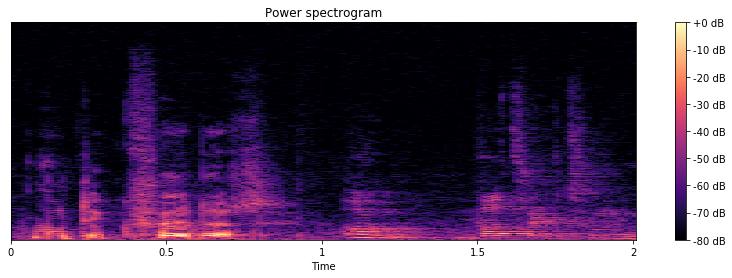

In [89]:
STFT = librosa.stft(music, n_fft=2048)
mag, phase = librosa.magphase(STFT)
plt.figure(figsize=(14,4))
librosa.display.specshow(librosa.amplitude_to_db(mag, ref=np.max), x_axis='time',sr=fs)
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.show()

### 2.	The Frequency spectrum is then processed with a mel scale filter resulting in a mel frequency spectrum. A mel scale filter constitutes of multiple bandpass filters, and the power of each filter band is computed. The spacing between the filters is non-linear to mimic the human auditory system (mel scale), here the number, the shape, and the center frequency of the band-pass filters can be varied. There is debate in the literature on what combination is best, suggesting that overlapping rectangular shaped filters are best.

In [90]:
D = np.abs(STFT)**2

In [91]:
S128 = librosa.feature.melspectrogram(S=D,n_mels=128)
S13 = librosa.feature.melspectrogram(S=D,n_mels=13)

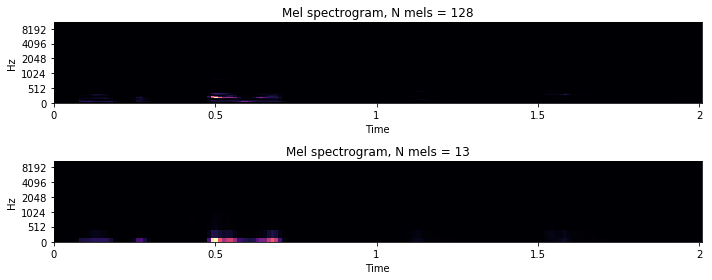

In [92]:
plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
librosa.display.specshow(S128, y_axis='mel', x_axis='time',sr=fs)
#plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram, N mels = 128')
plt.tight_layout()
plt.subplot(2, 1, 2)
librosa.display.specshow(S13, y_axis='mel', x_axis='time',sr = fs)
#plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram, N mels = 13')
plt.tight_layout()
plt.show()


### 3.	The mel frequency spectrum is then processed by taking the log to mimic the human perception of loudness.

In [93]:
S128db = librosa.power_to_db(S128)

In [94]:
S13db = librosa.power_to_db(S13)

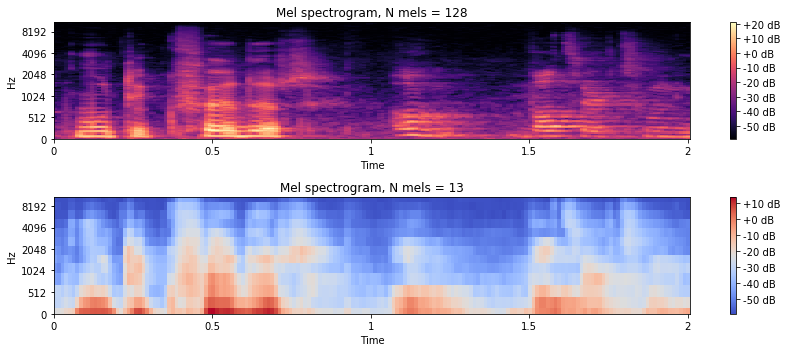

In [95]:
plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
librosa.display.specshow(S128db, y_axis='mel', x_axis='time',sr=fs)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram, N mels = 128')
plt.tight_layout()
plt.subplot(2, 1, 2)
librosa.display.specshow(S13db, y_axis='mel', x_axis='time',sr = fs)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram, N mels = 13')
plt.tight_layout()
plt.show()

### 4. Next a Discrete Cosine Transform is taken which results in cepstral coefficients. This aims to eliminate the speaker dependent characteristics. The cepstrum can be interpreted as a spectrum of a spectrum. Explaination for DCT instead of FFT:  Instead of the Fourier Transform the discrete cosine transform can be used because the absolute value of the spectrum, respectively the periodic continuation of the signal, is real and symmetric.

In [96]:
mfccs128 = librosa.feature.mfcc(S=S128db,sr=fs, n_mfcc = 128)
mfccs13 = librosa.feature.mfcc(S=S13db,sr=fs, n_mfcc = 13)

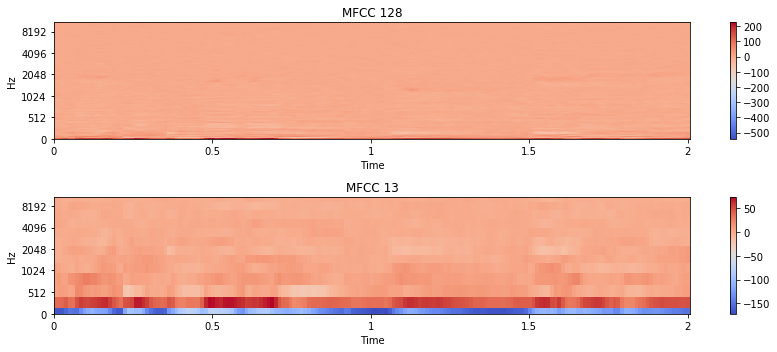

In [97]:
plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
librosa.display.specshow(mfccs128, y_axis='mel', x_axis='time',sr=fs)
plt.colorbar()
plt.title('MFCC 128')
plt.tight_layout()
plt.subplot(2, 1, 2)
librosa.display.specshow(mfccs13, y_axis='mel', x_axis='time',sr=fs)
plt.colorbar()
plt.title('MFCC 13')
plt.tight_layout()
plt.show()